In [1]:

from tyssue.core.monolayer import Monolayer, MonolayerWithLamina, set_model
from tyssue.core.sheet import Sheet
from tyssue.geometry.bulk_geometry import BulkGeometry, MonoLayerGeometry
from tyssue.dynamics.bulk_model import BulkModel, LaminaModel
from tyssue.io import hdf5
from tyssue import config
from tyssue.core.generation import extrude
from tyssue.solvers.sheet_vertex_solver import Solver

from tyssue.draw.vispy_draw import vp_view
from tyssue.draw.plt_draw import sheet_view
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ls 

after.obj                     Fold formation - Sheet.ipynb
before_apoptosis_anchors.hf5  Leg_joint_monolayer.ipynb
before_apoptosis.hf5          Mixed Geometry.ipynb
before_apoptosis.hf5.hf5      Monolayer apoptosis.ipynb
before.hf5                    render.blend
before_monolayer              render.blend1
before.png                    render.stl


In [58]:
sheet = Sheet.planar_sheet_3d('base', 5, 5, 1, 1)
sheet.sanitize()

sheet.reset_topo()
sheet.reset_index()

datasets = extrude(sheet.datasets,
                   method='translation',
                   vector=[0, 0, -1])


/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/config/json_parser.py:44: UserWarning: Deprecated
  warnings.warn('Deprecated')
/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/tyssue-0.1-py3.5.egg/tyssue/config/geometry/__init__.py:181: UserWarning: Deprecated, use spherical_sheet(), cylindrical_sheet() or flat_sheet() instead
  warnings.warn("Deprecated, use spherical_sheet(), "


In [59]:
mono = MonolayerWithLamina('small', datasets,
                           config.geometry.bulk_spec())
BulkGeometry.update_all(mono)

In [60]:
scene, view = vp_view(mono)

In [61]:
# ## Settings for the quasi-static model
# ### Apical layer
apical_spec = {
    'edge': {
        'line_tension': 0.12,
        'prefered_length': 0.0,
        'length_eleasticity': 0.0},
    'face': {
        'contractility': 0.04,
        'prefered_area': 1.0,
        'area_elasticity': 1.0},
    'cell': {
        'prefered_vol': 1.0,
        'vol_elasticity': 1.0},
    'settings': {
        'grad_norm_factor': 1.0,
        'nrj_norm_factor': 1.0},}

# ### Modifier for each segment of the stratum
modifiers = {
    'sagittal': {
        'edge': {
            'line_tension': 0.1},
        'face': {
            'contractility': 0.05,
            'prefered_area': 1.} # increase the sagittal prefered area to obtain anisotropic cells
    },
    'basal': {
        'edge': {
            'line_tension': 0.12},
        'face': {
            'contractility': 0.04,
            'prefered_area': 1.0}},
    'lamina': {
        'face': {
            'contractility': 0.0},
        'edge': {
            'line_tension': 0.0}}
    }

set_model(mono, BulkModel, apical_spec, modifiers)
mono.edge_df.loc[mono.lamina_edges, 'length_elasticity'] = 0.2
mono.edge_df.loc[mono.lamina_edges, 'prefered_length'] \
    = mono.edge_df.loc[mono.lamina_edges, 'length'].mean() 

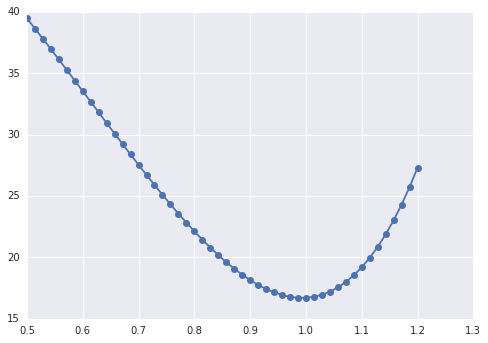

In [62]:
energies = []
deltas = np.linspace(0.5, 1.2)
for delta in deltas:
    BulkGeometry.scale(mono, delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    energies.append(LaminaModel.compute_energy(mono))
    BulkGeometry.scale(mono, 1/delta,
                       mono.coords)
    BulkGeometry.update_all(mono)
    

fig, ax = plt.subplots()

ax.plot(deltas, energies, 'o-')



In [63]:
delta = deltas[np.argmin(energies)]

BulkGeometry.scale(mono, delta, mono.coords)
BulkGeometry.update_all(mono)

In [64]:
%pdb

Automatic pdb calling has been turned OFF


In [65]:
res = Solver.find_energy_min(mono, BulkGeometry, LaminaModel)

In [ ]:
scene, view = vp_view(mono)

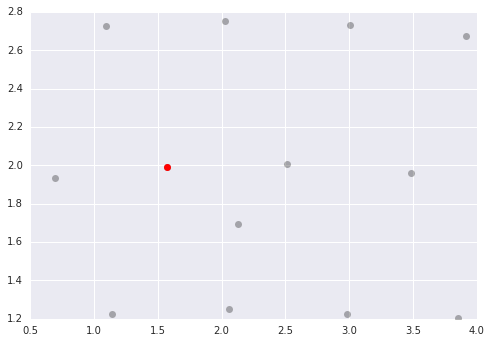

In [70]:
fig, ax = plt.subplots()
ax.plot(mono.cell_df.x, 
        mono.cell_df.y, 'ko', alpha=0.3)

cell = 5
ax.plot(mono.cell_df.loc[cell, 'x'], 
        mono.cell_df.loc[cell, 'y'], 'ro')


In [71]:
from tyssue.behaviors.monolayer_events import MonoLayerEvents
events = MonoLayerEvents(mono, BulkModel, MonoLayerGeometry)
cell = 35
cell_faces = set(mono.edge_df[mono.edge_df['cell'] == cell]['face'])
is_apical = mono.face_df.loc[cell_faces, 'segment'] == 'apical'

apical_face, = mono.face_df.loc[cell_faces][is_apical].index



ValueError: not enough values to unpack (expected 1, got 0)

In [42]:
def set_edge_color(sheet, col):

    cmap = plt.cm.get_cmap('viridis')

    e_color = (sheet.edge_df[col] -
               sheet.edge_df[col].min()) / sheet.edge_df[col].ptp()
    return cmap(e_color)

def segment_view(mono, segment,
                 coords=['x', 'y'], **draw_specs):
    
    dsets = {elem: df.loc[mono.segment_index(segment, elem)]
             for elem, df in mono.datasets.items()
             if elem != 'cell'}
    specs = {elem: sp for elem, sp in mono.specs.items()
             if elem != 'cell'}
    sheet = Sheet(segment, dsets, specs)
    return sheet_view(sheet, coords, **draw_specs)

In [43]:
draw_specs = config.draw.sheet_spec()
edge_z = mono.upcast_srce(mono.vert_df['z'])
mono.edge_df['z'] = edge_z
draw_specs['edge']['color'] = set_edge_color(mono, 'z')
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.001

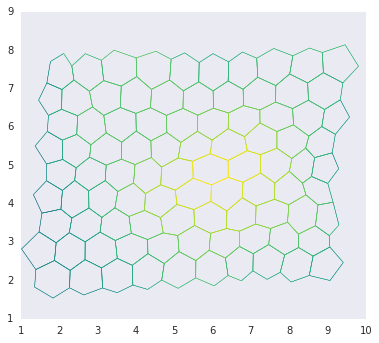

In [44]:
ax, fig = segment_view(mono, 'apical', coords=['x', 'y'], **draw_specs)

In [45]:
for i in range(10):

    events.contract(apical_face, 0.2)
    events.shrink(cell, 0.2)
    events.ab_pull(cell, 0.2)
    Solver.find_energy_min(mono, BulkGeometry, BulkModel)
    

In [46]:
import seaborn as sns

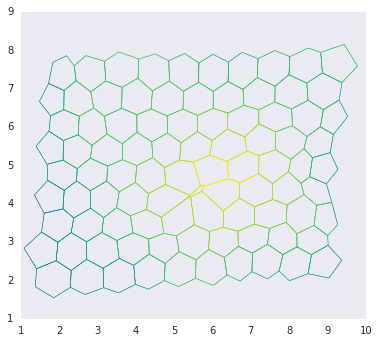

In [47]:
ax, fig = segment_view(mono, 'apical', coords=['x', 'y'], **draw_specs)

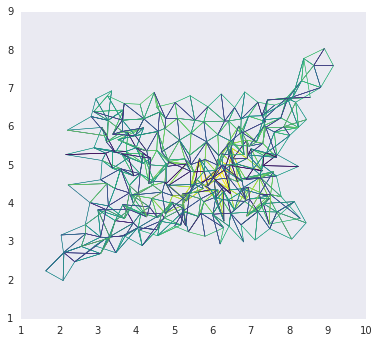

In [48]:
ax, fig = segment_view(mono, 'basal', coords=['x', 'y'], **draw_specs)

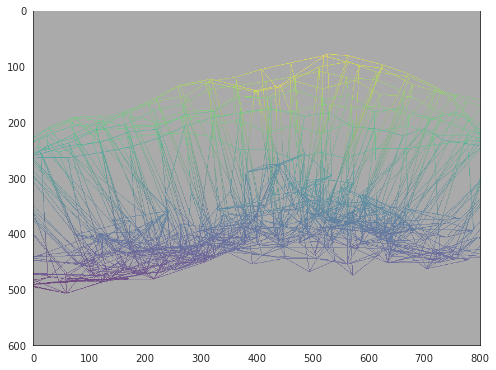

In [51]:
scene, view = vp_view(mono, **draw_specs)

img = scene.render()

fig, ax = plt.subplots()
ax.imshow(img)
ax.grid()
fig.set_size_inches(8, 8)

In [18]:
from tyssue.dynamics.base_gradients import length_grad
from tyssue.dynamics.effectors import elastic_force
from tyssue.utils.utils import _to_3d

eptm = mono
grad = BulkModel.compute_gradient(eptm)
lamina = eptm.edge_df.loc[eptm.lamina_edges]

grad_lij = length_grad(eptm).loc[eptm.lamina_edges]
kl_l0 = elastic_force(lamina,
                      var='length',
                      elasticity='length_elasticity',
                      prefered='prefered_length')
grad_l_ = _to_3d(kl_l0) * grad_lij
grad_l_ = grad_l_.set_index(lamina['srce'])

grad_l_srce = grad_l_.sum(level='srce')
grad_l_ = grad_l_.set_index(lamina['trgt'])
grad_l_trgt = grad_l_.sum(level='trgt')
grad_l = (grad_l_srce - grad_l_trgt)/2
grad.loc[grad_l.index] += grad_l
